In [ ]:
import json
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
sentences = []
labels = []

with open('quotes.txt', 'r') as f:
    for quote in f:
        sentences.append(str(quote.strip()))

with open('labels.txt', 'r') as f:
    for label in f:
        if 'vacuous' in label:
            label = 0
        else:
            label = 1
        labels.append(label)

In [ ]:
import random

combined = list(zip(sentences, labels)) #shuffling
random.shuffle(combined)

sentences[:], labels[:] = zip(*combined)

## Hyper-parameters

In [ ]:
vocab_size = 10000
embedding_dim = 8
max_length = 150
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = int(len(labels) * 0.8)

In [ ]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## Multilayer Perceptrons

In [ ]:
model1 = tf.keras.Sequential([ #list of layers to add to the model
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length), #10k * 8 = 80k
    tf.keras.layers.GlobalAveragePooling1D(), #if Flatten() crashes
    tf.keras.layers.Dense(16, activation='tanh'), #(8+1)*16
    tf.keras.layers.Dense(1, activation='sigmoid') #(16+1)
])

model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model1.summary()

In [ ]:
num_epochs = 50
history1 = model1.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1)

## With a Single Layer of LSTM

In [ ]:
model2 = tf.keras.Sequential([ 
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length), #10k*8 = 80k‬
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)), # 2*4*[16*(16+8) + 16] (g = 2*4, h = 16, i = 8)
    tf.keras.layers.Dense(16, activation = 'tanh'), #(32+1) * 16 = 528
    tf.keras.layers.Dense(1, activation = 'sigmoid') #(16+1)  
]) 

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model2.summary()

In [ ]:
NUM_EPOCHS = 50
history2 = model2.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose = 1)

## With Multiple Layers of LSTM

In [ ]:
model3 = tf.keras.Sequential([ 
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8)),
    tf.keras.layers.Dense(16, activation = 'tanh'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model3.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model3.summary()

In [ ]:
EPOCHS = 50
history3 = model3.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose = 1)

## With GRU

In [ ]:
model4 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(16)),
    tf.keras.layers.Dense(16, activation='tanh'), 
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model4.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model4.summary()

In [ ]:
EPOCHS = 50
history4 = model4.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose = 1)

## With 1D Convolutional Layer

In [ ]:
model5 = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(32, 5, activation='relu'), # [i × f × o] + o, (i = 8, f = 5, o = 32)
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16, activation='tanh'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model5.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model5.summary()

In [ ]:
EPOCHS = 50
history5 = model5.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose = 1)

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

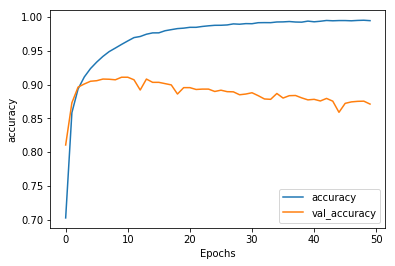

In [146]:
plot_graphs(history1, 'accuracy')

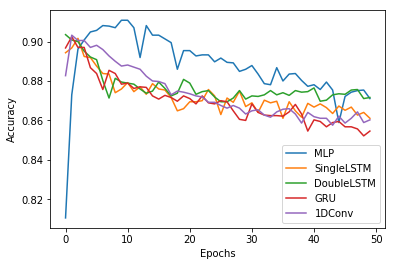

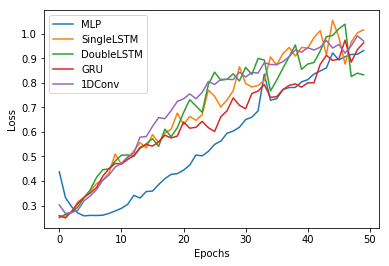

In [145]:
histories = [history1, history2, history3, history4, history5]
for log in histories:
    plt.plot(log.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['MLP', 'SingleLSTM', 'DoubleLSTM', 'GRU', '1DConv'])
plt.show()

for log in histories:
    plt.plot(log.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['MLP', 'SingleLSTM', 'DoubleLSTM', 'GRU', '1DConv'])
plt.show()

## Acqure weights

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(sequence):
    return ' '.join([reverse_word_index.get(i, '?') for i in sequence])

In [ ]:
e = model1.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)
print(weights)

## Output weights
metadat and vectors can be uploaded at http://projector.tensorflow.org/ for visualizations

In [ ]:
import io

out_v = io.open('vecs_pseudo-profound.tsv', 'w', encoding='utf-8')
out_m = io.open('meta_pseudo-profound.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

## Classification

In [147]:
texts = ["You are basic!", 'Live, laugh, love!']
sequences = tokenizer.texts_to_sequences(texts)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
models = [model1, model2, model3, model4, model5]
model_names = ['MLP', '1LSTM', '2LSTM', 'GRU', '1DConv']
print('\t' + texts[0] + '\t' + texts[1])
for model in zip(model_names, models):
    print(model[0], end = '\t')
    print(model[1].predict(padded)[0][0], end = '\t')
    print(model[1].predict(padded)[1][0])

	You are basic!	Live, laugh, love!
MLP	0.82606065	0.00919458
1LSTM	0.998755	0.10788591
2LSTM	0.7130968	0.36986926
GRU	0.83411187	0.08223568
1DConv	0.9997211	0.4741875
